In [34]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

In [35]:
train_df = pd.read_csv('./train.csv')
features_df = pd.read_csv('./features.csv')
stores_df = pd.read_csv('./stores.csv')
test_df = pd.read_csv('./test.csv')

data = train_df.merge(features_df, on=['Store', 'Date', 'IsHoliday'], how='inner')
final_df = data.merge(stores_df, on=['Store'], how='inner')


In [36]:
def create_sequences(data, seq_length):
    """Create sequences for CNN-LSTM input"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [37]:
tore20 = final_df[final_df['Store'] == 20]
store20 = store20[['Date','Weekly_Sales']]
store20 = store20.groupby('Date').sum()
store20.reset_index(inplace=True)
store20['Date'] = pd.to_datetime(store20['Date'])

# Scale the data
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(store20[['Weekly_Sales']])

In [38]:
seq_length = 12  # Using last 12 weeks to predict next week
X, y = create_sequences(sales_scaled, seq_length)

# Reshape X for CNN input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into train and test sets
train_size = 120
X_train = X[:train_size-seq_length]
y_train = y[:train_size-seq_length]
X_test = X[train_size-seq_length:]
y_test = y[train_size-seq_length:]


In [39]:
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(seq_length, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=0
)


In [40]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train.flatten()])
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test.flatten()])

# Calculate metrics
mape = mean_absolute_percentage_error(y_test_inv.T, test_predict) * 100
mae = mean_absolute_error(y_test_inv.T, test_predict)
mse = mean_squared_error(y_test_inv.T, test_predict)
r2 = r2_score(y_test_inv.T, test_predict)


1/1 [==============================] - 0s 12ms/step


In [41]:
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R2: {r2:.4f}")


MAPE: 7.12%
MAE: 145825.73
MSE: 27060951461.97
R2: -1.8566


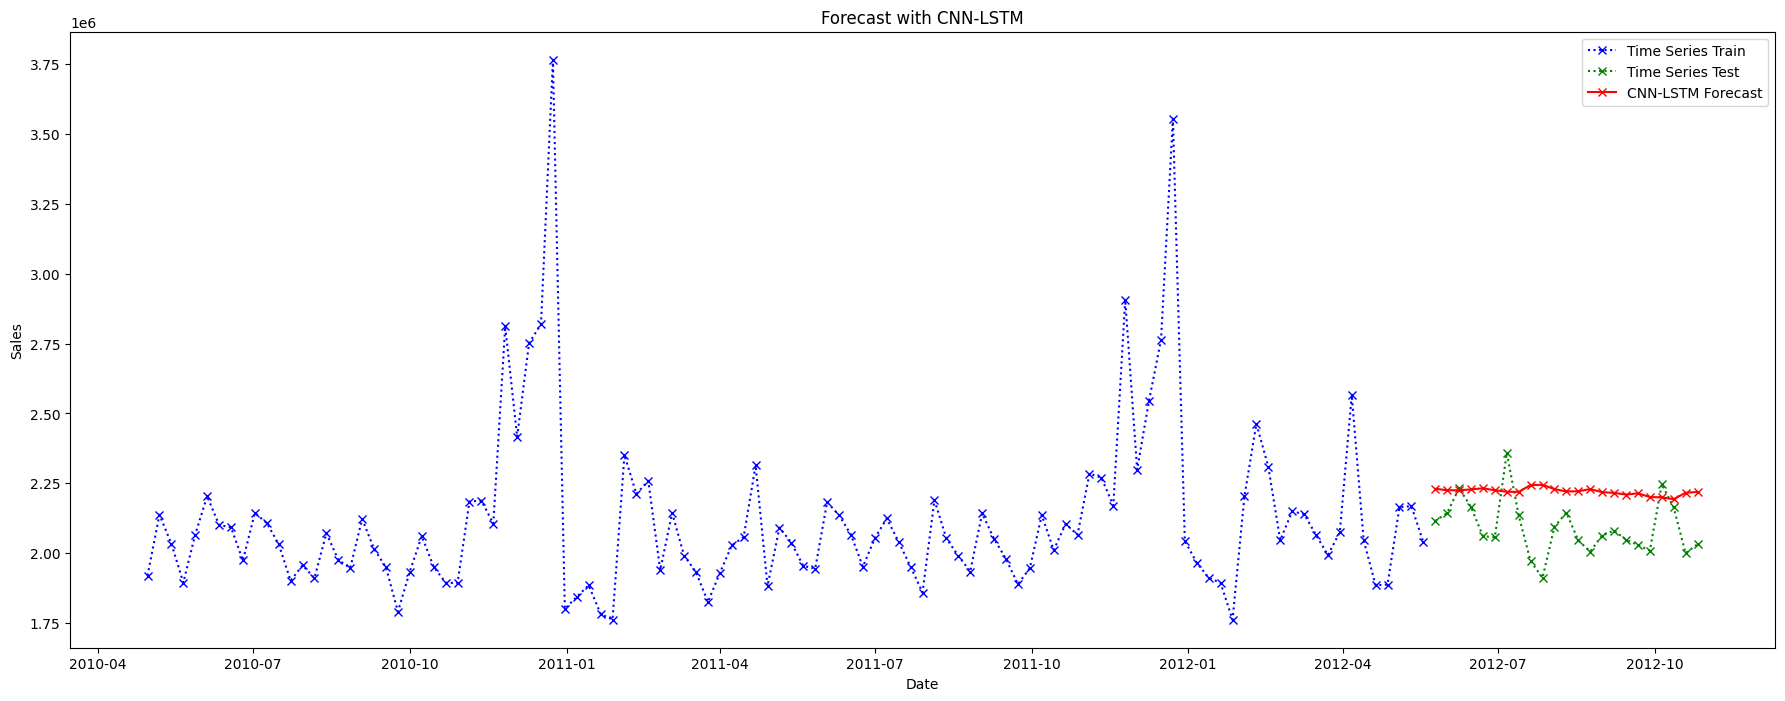

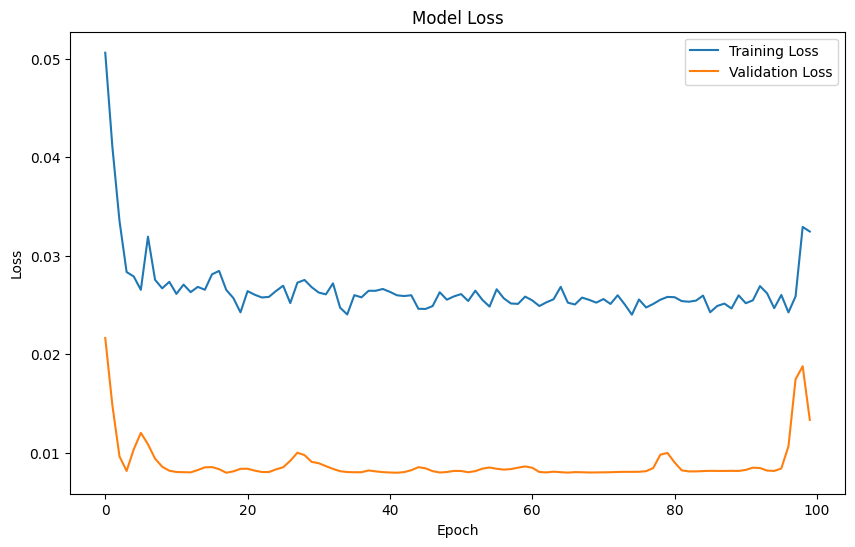

In [42]:
plt.figure(figsize=(22,8))

# Plot training data
train_dates = store20['Date'].iloc[seq_length:train_size]
plt.plot(train_dates, y_train_inv.T, 'bx:', label='Time Series Train')

# Plot test data
test_dates = store20['Date'].iloc[train_size:]
plt.plot(test_dates, y_test_inv.T, 'gx:', label='Time Series Test')

# Plot predictions
plt.plot(test_dates, test_predict, 'rx-', label='CNN-LSTM Forecast')

plt.legend()
plt.title("Forecast with CNN-LSTM")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.show()

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [43]:
def forecast_store_cnn_lstm(store_data, train_size=120, seq_length=12):
    # Prepare data
    store_x = store_data[['Date','Weekly_Sales']]
    store_x = store_x.groupby('Date').sum()
    store_x.reset_index(inplace=True)
    store_x['Date'] = pd.to_datetime(store_x['Date'])
    
    # Scale data
    scaler = MinMaxScaler()
    sales_scaled = scaler.fit_transform(store_x[['Weekly_Sales']])
    
    # Create sequences and reshape for CNN input
    X, y = create_sequences(sales_scaled, seq_length)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # Split data
    X_train = X[:train_size-seq_length]
    y_train = y[:train_size-seq_length]
    X_test = X[train_size-seq_length:]
    y_test = y[train_size-seq_length:]
    
    # Create and train model
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(seq_length, 1)),
        MaxPooling1D(pool_size=2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    
    # Make predictions
    test_predict = model.predict(X_test)
    
    # Inverse transform predictions
    test_predict = scaler.inverse_transform(test_predict)
    y_test_inv = scaler.inverse_transform([y_test.flatten()])
    
    # Calculate metrics
    mape = mean_absolute_percentage_error(y_test_inv.T, test_predict) * 100
    mae = mean_absolute_error(y_test_inv.T, test_predict)
    
    return mape, mae

In [ ]:
lstm_results_cnn_lstm = {}
for store in final_df['Store'].unique():
    store_data = final_df[final_df['Store'] == store]
    mape_cnn_lstm, mae_cnn_lstm = forecast_store_cnn_lstm(store_data)
    lstm_results_cnn_lstm[store] = [mape_cnn_lstm, mae_cnn_lstm]



1/1 [==============================] - 0s 206ms/step
{1: [4.5921598261013035, 73630.9897826087], 2: [3.9791667682684375, 75074.5495652174], 3: [3.2747256631150004, 13693.036250000005], 4: [3.8098861563235755, 80661.59217391307], 5: [4.858283126445833, 15750.443043478259], 6: [5.630143080073942, 90432.79478260867], 7: [8.699377778486745, 56996.11907608696], 8: [5.656011621232132, 52296.97750000001], 9: [4.3081235380434135, 23513.816521739143], 10: [6.109143742518769, 105712.23391304351], 11: [4.967857551711699, 66830.29847826088], 12: [4.348333925037615, 42312.36826086957], 13: [2.7294853942249717, 56265.17499999997], 14: [15.733973889274179, 253174.61934782614], 15: [6.650702131038853, 39506.739130434784], 16: [5.351313693912243, 29869.526902173904], 17: [6.02313758446168, 59600.7502173913], 18: [4.896233506623681, 50564.660869565225], 19: [7.450089977432945, 100985.97043478262], 20: [4.686567723272149, 96766.55739130432], 21: [16.06047238643927, 108305.37934782609], 22: [4.50524809271

In [45]:
for store, metrics in lstm_results_cnn_lstm.items():
    print(f"Store {store}: MAPE = {metrics[0]}%, MAE = {metrics[1]}")

Store 1: MAPE = 4.5921598261013035%, MAE = 73630.9897826087
Store 2: MAPE = 3.9791667682684375%, MAE = 75074.5495652174
Store 3: MAPE = 3.2747256631150004%, MAE = 13693.036250000005
Store 4: MAPE = 3.8098861563235755%, MAE = 80661.59217391307
Store 5: MAPE = 4.858283126445833%, MAE = 15750.443043478259
Store 6: MAPE = 5.630143080073942%, MAE = 90432.79478260867
Store 7: MAPE = 8.699377778486745%, MAE = 56996.11907608696
Store 8: MAPE = 5.656011621232132%, MAE = 52296.97750000001
Store 9: MAPE = 4.3081235380434135%, MAE = 23513.816521739143
Store 10: MAPE = 6.109143742518769%, MAE = 105712.23391304351
Store 11: MAPE = 4.967857551711699%, MAE = 66830.29847826088
Store 12: MAPE = 4.348333925037615%, MAE = 42312.36826086957
Store 13: MAPE = 2.7294853942249717%, MAE = 56265.17499999997
Store 14: MAPE = 15.733973889274179%, MAE = 253174.61934782614
Store 15: MAPE = 6.650702131038853%, MAE = 39506.739130434784
Store 16: MAPE = 5.351313693912243%, MAE = 29869.526902173904
Store 17: MAPE = 6.02